# Training d'un agent Othello

## Importation des modules

In [1]:
from Board import Board
from Agent import Memory, Model, encode_action, reward_from_signal, game_over_from_signal

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
from IPython.display import display # to display images

import random
import numpy as np

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Définition d'un mmodèle de réseau de neurones

In [2]:
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        # Input (2, 8, 8,)
        # Output (65,)
        self.input_layer = nn.Conv2d(2, 128, 3, padding=1)
        self.hidden_layer_1 = nn.Conv2d(128, 128, 3, padding=1)
        self.hidden_layer_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.hidden_layer_3 = nn.Linear(128*8*8, 128*8)
        self.hidden_layer_4 = nn.Linear(128*8, 128)
        self.output_layer = nn.Linear(128, 65)

    def forward(self, x):
        x = F.relu(self.input_layer(x))
        x = F.relu(self.hidden_layer_1(x))
        x = F.relu(self.hidden_layer_2(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.hidden_layer_3(x))
        x = F.relu(self.hidden_layer_4(x))
        output = self.output_layer(x)
        return output
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

## Méthode de visualisation des q_matrix

In [3]:
def render_q(q: list):
    dimension = (128, 128)
    max_negative = np.min([np.min(q), 0])
    max_positive = np.max([np.max(q), 0])
    image = Image.new('RGBA', dimension, (255,255,225,255))
    draw = ImageDraw.Draw(image)
    y = 0
    i = 0
    for l in range(8):
        x = 0
        for c in range(8):
            xy = [(x + 1, y + 1), (x + 14, y + 14)]
            r = q[i]
            if r > 0:
                # a = int(r / max_positive * 255)
                a = min(255, max(0, int(r * 255)))
                color = (0,0,255,a)
                draw.rectangle(xy, fill=color)
            elif r < 0:
                a = min(255, max(0, int(-r * 255)))
                # a = int(r / max_negative * 255)
                color = (255,0,0,a)
                draw.rectangle(xy, fill=color)
            x += 16
            i += 1
        y += 16
    display(image)

## Premiere étape : apprentissage d'un seul coup

Q_matrix of initial state, before training:


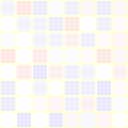

Target Q matrix:


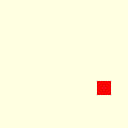

Q_matrix of initial state, after training:


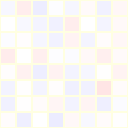

In [4]:
# New model
board = Board()
model = Model()
learning_rate = 0.3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Get initial state from the board
initial_s, signal = board.reset()
initial_s = torch.tensor(initial_s, dtype=torch.float).unsqueeze(0)

# Predict an action
a_scores = model(initial_s)
a = torch.argmax(a_scores).item()
encoded_a = encode_action(a)

# Perform the action in the game
s, signal = board.step(encoded_a)
next_s = torch.tensor(s, dtype=torch.float).unsqueeze(0)

# Process the signal
r = reward_from_signal(signal, board)
done = game_over_from_signal(signal, board)

# Q Learning
target_q = torch.zeros((65,), dtype=torch.float)

# Add the reward and action
target_q[a] = r

# Render model before the training
print("Q_matrix of initial state, before training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

# Toggle on train mode
model.train()

for i in range(16):
    # Compute loss on the difference between model output and target_q
    q_pred = model(torch.tensor(initial_s, dtype=torch.float))
    loss = criterion(torch.tensor(target_q, dtype=torch.float), q_pred)

    # Let the optimizer do the backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print("Target Q matrix:")
render_q(target_q.tolist())

# Render model after the training
print("Q_matrix of initial state, after training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

## Deuxième étape : apprentissage du premier état avec historique

Q_matrix of initial state, before training:


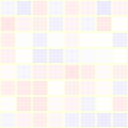

Target Q matrix:


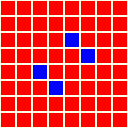

Q_matrix of initial state, after training:


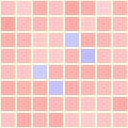

In [9]:
# New model
board = Board()
model = Model()
learning_rate = 0.3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# Render model before the training
print("Q_matrix of initial state, before training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

# (Action, Reward) container for each action
history = []

# Populating the history with every possible move
for i_action in range(65):
    # Reset the board
    board.reset()

    # Predict an action
    a = i_action
    encoded_a = encode_action(a)

    # Perform the action in the game
    s, signal = board.step(encoded_a)

    # Process the signal
    r = reward_from_signal(signal, board)

    # Add the record to history
    history.append((a, r))

# Q Learning matrix for the initial state
target_q = torch.zeros((65,), dtype=torch.float)

# Add the reward and action for each game in history
# NOTE: ça overwrite si y'a plusieurs valeurs
for (a, r) in history:
    target_q[a] = r

print("Target Q matrix:")
render_q(target_q.tolist())

# Toggle on train mode
model.train()

for i_batch in range(16):
    # Compute loss on the difference between model output and target_q
    q_pred = model(torch.tensor(initial_s, dtype=torch.float))
    loss = criterion(torch.tensor(target_q, dtype=torch.float), q_pred)

    # Let the optimizer do the backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Render model after the training
print(f"Q_matrix of initial state, after training:")
q_pred = model(torch.tensor(initial_s, dtype=torch.float))
render_q(q_pred.tolist()[0])

## Troisième étape : à combien de coup est-ce que l'agent "comprend" le premier état ?

Target Q matrix: step 2


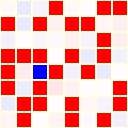

Q_matrix of initial state, after training: step 2


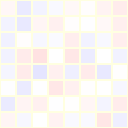

Target Q matrix: step 32


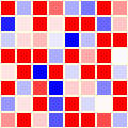

Q_matrix of initial state, after training: step 32


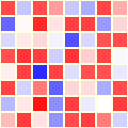

Target Q matrix: step 62


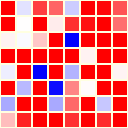

Q_matrix of initial state, after training: step 62


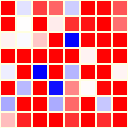

Target Q matrix: step 92


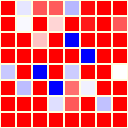

Q_matrix of initial state, after training: step 92


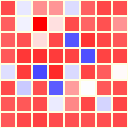

In [13]:
# New model
board = Board()
model = Model()
learning_rate = 0.3
batch_size = 32
n_epochs = 128 # On aura pas joué tous les coups mais OK
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# (Action, Reward) container for each action
history = []

# Populating the history with every possible move
for i_epoch in range(n_epochs):
    # Reset the board
    initial_s, _ = board.reset()
    initial_s = torch.tensor(initial_s, dtype=torch.float).unsqueeze(0)

    # Play a random action
    a = torch.randint(0, 65, (1,)).item()
    encoded_a = encode_action(a)

    # Perform the action in the game
    s, signal = board.step(encoded_a)

    # Process the signal
    r = reward_from_signal(signal, board)

    # Add the record to history
    history.append((a, r))

    # Continue playing if we don't have enough moves to learn in the history
    if len(history) <= batch_size:
        continue
    # Keep history the size of the batch size by removing first element in list
    history.pop(0)

    # Q Learning matrix for the initial state
    # NOTE: Je pense qu'il faudrait partir de la prédiction du modèle
    # et y ajouter les rewards, les cases où il y a 0 peuvent peut-être
    # poser problème
    target_q = model(initial_s).view(-1)# torch.zeros((65,), dtype=torch.float)

    # Add the reward and action for each game in history
    # NOTE: ça overwrite si y'a plusieurs valeurs, donc batch_size devrait être < 65
    # TODO: moyenne des valeurs ? pas d'overwrite ?
    for (a, r) in random.sample(history, batch_size):
        target_q[a] = r

    # Toggle on train mode
    model.train()

    # for i_batch in range(4):
    # Compute loss on the difference between model output and target_q
    q_pred = model(torch.tensor(initial_s, dtype=torch.float))
    loss = criterion(torch.tensor(target_q, dtype=torch.float), q_pred)

    # Let the optimizer do the backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    # Display matrixes
    if (i_epoch - batch_size) % 30 == 1:
        # Render model after the training
        print(f"Target Q matrix: step {i_epoch - batch_size + 1}")
        render_q(target_q.tolist())

        print(f"Q_matrix of initial state, after training: step {i_epoch - batch_size + 1}")
        q_pred = model(torch.tensor(initial_s, dtype=torch.float))
        render_q(q_pred.tolist()[0])

## Etape 4 : mouvements futurs